In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
import pickle

In [2]:
import sklearn
sklearn.set_config(display='diagram')

In [3]:
# read in all the data

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
print(f"Train shape: {train.shape}",f"\nTest Shape: {test.shape}")

Train shape: (7613, 5) 
Test Shape: (3263, 4)


In [5]:
# see if we have any missing values

train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

A lot of the location data is missing, to be precise 33% of the training locations are missing. This will be used later to map the tweets geospatially so we will have to do some cleaning.

In [6]:
np.round(train['location'].isnull().sum()/len(train),2)

0.33

In [7]:
# create a df with both train and test sets
full_data = pd.concat([train,test])

In [8]:
full_data.shape

(10876, 5)

In [9]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10876 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 509.8+ KB


In [10]:
[re.search("https?://\S+|www\.\S+",x) for x in train['text']]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 <re.Match object; span=(33, 55), match='http://t.co/lHYXEOHY6C'>,
 <re.Match object; span=(45, 67), match='http://t.co/YAo1e0xngw'>,
 <re.Match object; span=(60, 82), match='http://t.co/2nndBGwyEi'>,
 None,
 <re.Match object; span=(54, 76), match='http://t.co/qqsmshaJ3N'>,
 None,
 <re.Match object; span=(33, 55), match='http://t.co/3ImaomknnA'>,
 <re.Match object; span=(118, 140), match='http://t.co/wDUEaj8Q4J'>,
 None,
 <re.Match object; span=(17, 39), match='http://t.co/rOI2NSmEJJ'>,
 None,
 None,
 None,
 <re.Match object; span=(70, 92), match='http://t.co/o9qknbfOFX'>,
 <re.Match object; span=(74, 96), match='http://t.co/TIyUliF5c6'>,
 <re.Match object; span=(75, 97), match='http://t.co/vl5TBR3wbr'>,
 None,
 <re.Match object; span=(17, 39), match='http://t.co/rOI2NSmEJ

We will need to remove all URL's from our text so let's make a function to do so.

In [11]:
def remove_url(text):
    url = re.compile("https?://\S+|www\.\S+")
    return url.sub(r'',text)

In [12]:
train['text'] = train['text'].apply(lambda x:remove_url(x))

Let's make sure that my function worked and removed all URL's from the text.

In [13]:
train['text'].apply(lambda x: re.findall(r"@\S+",x))

0                                 []
1                                 []
2                                 []
3                                 []
4                                 []
                    ...             
7608                              []
7609    [@aria_ahrary, @TheTawniest]
7610                              []
7611                              []
7612                              []
Name: text, Length: 7613, dtype: object

Let's remove mentions as well.

In [14]:
def remove_mentions(text):
    url = re.compile("@\S+")
    return url.sub(r"",text)

In [15]:
train['text']=train['text'].apply(lambda x: remove_mentions(x))

In [16]:
train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

Let's do some EDA on our Text column and compare disaster to non disaster tweets.

In [17]:
X = train['text']
y= train['target']

In [18]:
y = y.replace({0:'Not a Disaster',1:'Disaster'})

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=42)

In [20]:
y.value_counts()

Not a Disaster    4342
Disaster          3271
Name: target, dtype: int64

### Linear SVC

In [21]:
svc_pipe = make_pipeline(TfidfVectorizer(), SVC())

In [22]:
svc_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())])

In [23]:
svc_pipe.score(X_test,y_test)

0.7967436974789915

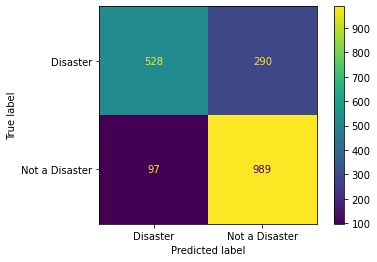

In [24]:
plot_confusion_matrix(svc_pipe,X_test,y_test)

Let's run the same pipeline with stop words removed.

In [25]:
svc_pipe2 = make_pipeline(TfidfVectorizer(stop_words='english'),SVC())

In [26]:
svc_pipe2.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('svc', SVC())])

In [27]:
svc_pipe2.score(X_test,y_test)

0.7930672268907563

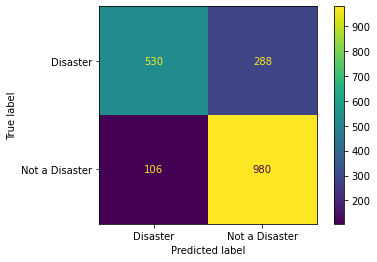

In [28]:
plot_confusion_matrix(svc_pipe2,X_test,y_test)

### Multinomial NB

In [29]:
nb_pipe = make_pipeline(TfidfVectorizer(),MultinomialNB())

In [30]:
nb_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [31]:
nb_pipe.score(X_test,y_test)

0.7983193277310925

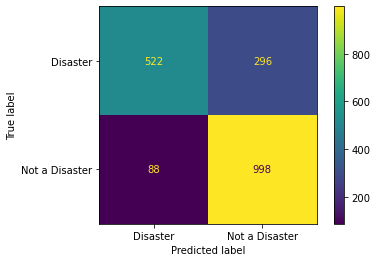

In [32]:
plot_confusion_matrix(nb_pipe,X_test,y_test)

In [33]:
nb_pipe2 = make_pipeline(TfidfVectorizer(stop_words='english'),MultinomialNB())

In [34]:
nb_pipe2.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [35]:
nb_pipe2.score(X_test,y_test)

0.7888655462184874

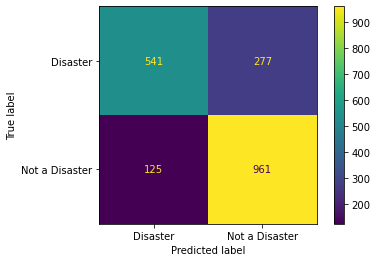

In [36]:
plot_confusion_matrix(nb_pipe2,X_test,y_test)

In [83]:
params = {
    'tfidfvectorizer__max_df':np.linspace(0.4,1,3),
    'tfidfvectorizer__ngram_range':[(1,1),(1,2),(2,3),(2,4)],
    'multinomialnb__alpha':[.01,.1,.5,1,2]
}

In [84]:
nb_gs = GridSearchCV(nb_pipe2,params,n_jobs=-1)

In [85]:
nb_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0.01, 0.1, 0.5, 1, 2],
                         'tfidfvectorizer__max_df': array([0.4, 0.7, 1. ]),
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 3), (2, 4)]})

In [86]:
nb_gs.best_params_

{'multinomialnb__alpha': 1,
 'tfidfvectorizer__max_df': 0.4,
 'tfidfvectorizer__ngram_range': (1, 1)}

In [87]:
nb_gs.score(X_test,y_test)

0.7888655462184874

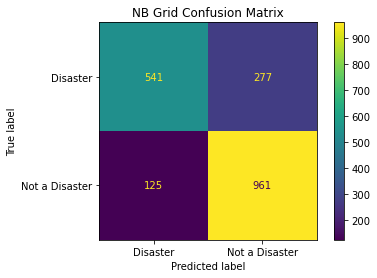

In [42]:
plot_confusion_matrix(nb_gs,X_test,y_test);
plt.title("NB Grid Confusion Matrix");

### Logistic Regression

In [43]:
lr_pipe = make_pipeline(TfidfVectorizer(stop_words='english'),LogisticRegression())

In [44]:
lr_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression())])

In [45]:
lr_pipe.score(X_test,y_test)

0.7909663865546218

In [46]:
params = {
    'tfidfvectorizer__max_df':np.linspace(0.4,1,3),
    'tfidfvectorizer__ngram_range':[(1,1),(1,2),(2,3),(2,4)],
    'tfidfvectorizer__max_features':range(500,5000,500),
    'logisticregression__solver':['liblinear','lbfgs'],
    'logisticregression__C':[0.2,0.5,1,2]
}

In [47]:
lr_gs = GridSearchCV(lr_pipe,params,n_jobs=-1)

In [48]:
lr_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.2, 0.5, 1, 2],
                         'logisticregression__solver': ['liblinear', 'lbfgs'],
                         'tfidfvectorizer__max_df': array([0.4, 0.7, 1. ]),
                         'tfidfvectorizer__max_features': range(500, 5000, 500),
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 3), (2, 4)]})

In [49]:
lr_gs.best_params_

{'logisticregression__C': 1,
 'logisticregression__solver': 'liblinear',
 'tfidfvectorizer__max_df': 0.4,
 'tfidfvectorizer__max_features': 4500,
 'tfidfvectorizer__ngram_range': (1, 2)}

In [50]:
lr_gs.score(X_test,y_test)

0.7930672268907563

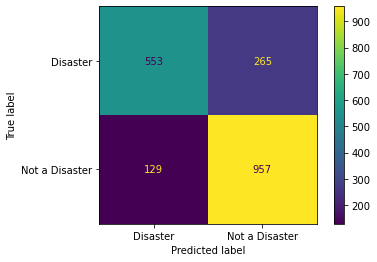

In [51]:
plot_confusion_matrix(lr_gs,X_test,y_test)

In [52]:
# create df of tfidf idf weights and index as token feature names

idf_weights = pd.DataFrame(lr_pipe.named_steps['tfidfvectorizer'].idf_,index=lr_pipe.named_steps['tfidfvectorizer'].get_feature_names(),columns=["idf_weights"])

In [53]:
x = idf_weights.sort_values(by='idf_weights',ascending=True)[:10]

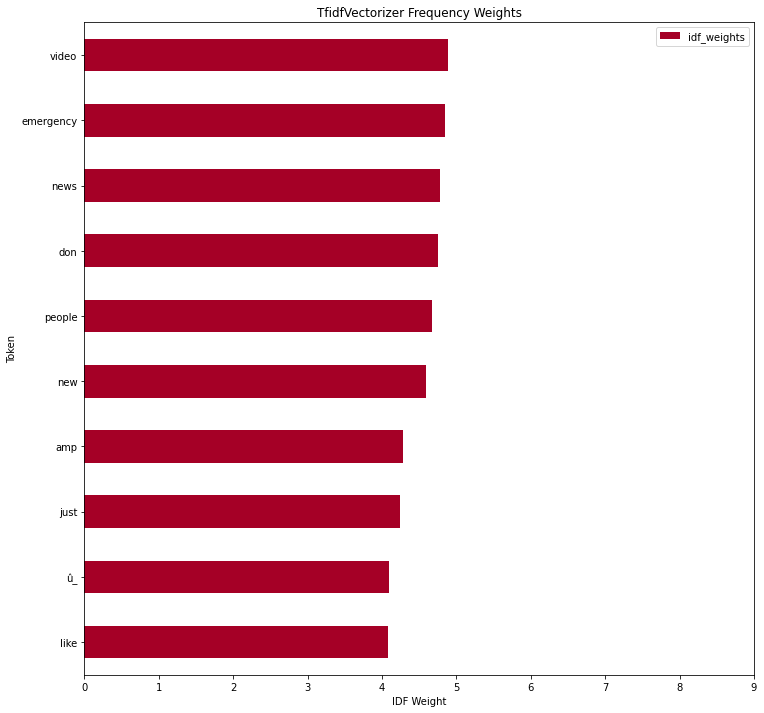

In [54]:
# plot tfidf vectorizer idf weights

x.plot(kind='barh',figsize=(12,12),colormap='RdYlGn')
plt.title('TfidfVectorizer Frequency Weights')
plt.ylabel('Token')
plt.xlabel('IDF Weight')
plt.xticks(ticks=list(range(10)));

In [55]:
# create df with

df_lr = pd.DataFrame(lr_pipe.named_steps['tfidfvectorizer'].fit_transform(X_train).toarray(),columns=lr_pipe.named_steps['tfidfvectorizer'].get_feature_names())

In [56]:
top_words =df_lr.sum().sort_values(ascending=False)[:20]

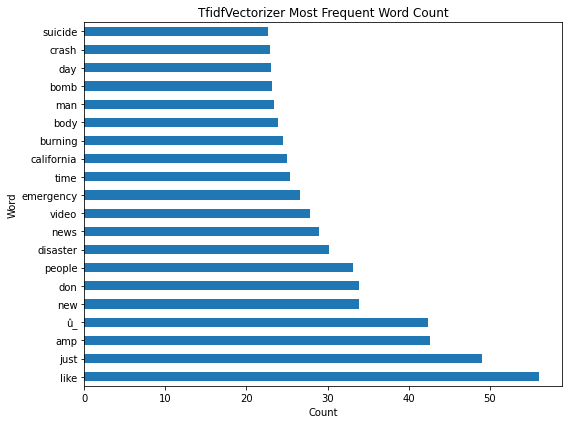

In [57]:
top_words.plot(kind='barh',figsize=(8,6))
plt.title("TfidfVectorizer Most Frequent Word Count")
plt.ylabel('Word')
plt.xlabel('Count')
plt.tight_layout();

### Gradient Boosting Classifier

In [58]:
# gbc_pipe = make_pipeline(TfidfVectorizer(stop_words='english'),GradientBoostingClassifier())

# gbc_pipe.fit(X_train,y_train)

# gbc_pipe.score(X_test,y_test)

# params = {
#     'tfidfvectorizer__max_df':np.linspace(0.4,1,3),
#     'tfidfvectorizer__ngram_range':[(1,1),(1,2),(1,3)],
#     'gradientboostingclassifier__learning_rate':[.001,.01,.1,1],
#     'gradientboostingclassifier__max_features':[None,1_000,10_000]
# }

# gs = GridSearchCV(gbc_pipe,params,n_jobs=-1)

# gs.fit(X_train,y_train)

# gs.best_params_

# gs.score(X_test,y_test)

### Voting Classifier

In [71]:
vc_pipe = make_pipeline(TfidfVectorizer(stop_words='english'),VotingClassifier(estimators=[('nb',MultinomialNB()),('svc',SVC()),('lr',LogisticRegression())]))

In [72]:
vc_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('votingclassifier',
                 VotingClassifier(estimators=[('nb', MultinomialNB()),
                                              ('svc', SVC()),
                                              ('lr', LogisticRegression())]))])

In [73]:
vc_pipe.score(X_test,y_test)

0.7946428571428571

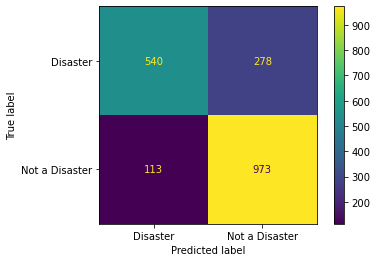

In [74]:
plot_confusion_matrix(vc_pipe,X_test,y_test)

In [63]:
submissions = pd.DataFrame({'id':test['id'],'target':vc_pipe.predict(test['text'])})

In [64]:
submissions.to_csv('subs',index=False)

In [65]:
submissions

,id,target
0,0,Disaster
1,2,Disaster
2,3,Disaster
3,9,Not a Disaster
4,11,Disaster
...,...,...
3258,10861,Disaster
3259,10865,Disaster
3260,10868,Disaster
3261,10874,Disaster


### Pickle

In [66]:
# now you can save it to a file
with open('tweet_class.pkl', 'wb') as f:
    pickle.dump(vc_pipe, f)

### Test Cases for Demonstration

In [67]:
test['text'][2]

'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all'

In [75]:
test['text'][8]

'What a nice hat?'

In [77]:
test['text'][30]

"Just got to love burning your self on a damn curling wand... I swear someone needs to take it away from me cuase I'm just accident prone."

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer

In [ ]:
lemmatizer=WordNetLemmatizer()

In [ ]:
train['text'].apply(lambda x: sent_tokenize(x.lower()))

In [ ]:
tokens = train['text'].apply(lambda x: word_tokenize(x))

In [ ]:
train['lemmas'] = train['text'].apply(lambda x: lemmatizer.lemmatize(x))

In [ ]:
pstemmer = PorterStemmer()

In [ ]:
[pstemmer.stem(x) for x in tokens]

In [ ]:
train['text'].apply(lambda x: pstemmer.stem(x))

In [106]:
test['text'][5]

"We're shaking...It's an earthquake"

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [ ]:
tokenizer = Tokenizer(num_words = 10_000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_matrix(X)

In [ ]:
tokenizer.word_counts

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state=42)

In [ ]:
model = Sequential()
model.add(Input)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=30,batch_size=64)